In [1]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np

In [3]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

2024-03-04 13:48:10.358227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 13:48:10.358281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 13:48:10.359541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '/n/holystore01/LABS/iaifi_lab/Users/smsharma/multimodal-data/logging/proposals/'
# run_name = 'glistening-kumquat-123'  # Fine tune with summaries
run_name = 'enchanting-lantern-125'  # Fine tune with abstracts

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [6]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

# restored_state = state

In [7]:
# ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
# restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=7000)

# if state is restored_state:
#     raise FileNotFoundError(f"Did not load checkpoint correctly")

In [8]:
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# raw_restored = orbax_checkpointer.restore('../logging/proposals/misunderstood-armadillo-34/ckpts/step_loss_7000/default/')

In [9]:
import orbax.checkpoint as ocp

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = ocp.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)

ckpt_mgr_load_ckpt = ocp.CheckpointManager(
    f"{ckpt_dir}/ckpts/",
    options=mgr_options,
)

restored_state = ckpt_mgr_load_ckpt.restore(
    ckpt_mgr_load_ckpt.latest_step(),
    args=ocp.args.StandardRestore(state)
)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [10]:
from utils.dataset_utils import make_dataloader, create_input_iter
import tensorflow as tf

files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")

ds = make_dataloader(files, batch_size=32, seed=42, split="val", shuffle=False, caption_type="summary")
batches = iter(ds)

In [11]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [12]:
from dm_pix import center_crop

In [13]:
def cosine_similarity(vec1, vec2):
    
    norm_vec1 = np.linalg.norm(vec1, axis=-1, keepdims=True)
    norm_vec2 = np.linalg.norm(vec2, axis=-1, keepdims=True)

    vec1 /= norm_vec1
    vec2 /= norm_vec2
        
    return np.dot(vec1, vec2)

## Text-to-image retrieval

In [14]:
from tqdm import tqdm

In [15]:
from utils.dataset_utils import make_dataloader, create_input_iter

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False, caption_type="summary")
batches = iter(ds)

In [16]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


In [18]:
import pandas as pd

df_sum_merged = pd.read_csv("../data/summary_v2.csv")

def get_propid_phenomena(caption):
    first_part = caption.split(";")[0]
    match = df_sum_merged[df_sum_merged["objects_phenomena"] == first_part][
        "proposal_id"
    ]
    return (
        match.values[0] if not (match.empty or pd.isna(match.values[0])) else "None"
    )

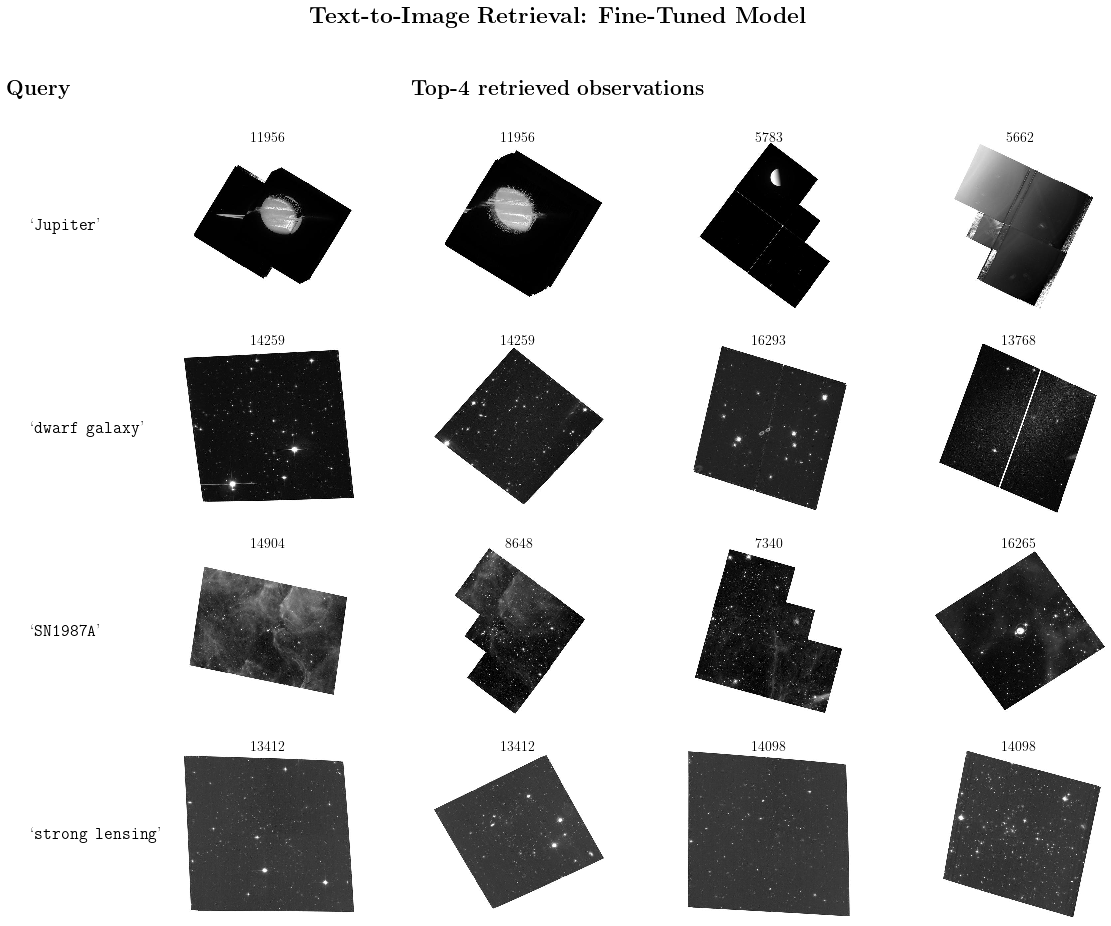

In [19]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc
import matplotlib

rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{color}")
rc("text.latex", preamble=r"\usepackage{xcolor}")

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
# queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 
queries = ["Jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 18 * len(queries) / 5.))

# Add a main title, make "fine-tuned model" in red color font
plt.suptitle(r"\textbf{Text-to-Image Retrieval: \textcolor{red}{Fine-Tuned Model}}", fontsize=23, fontweight='bold')

axes_list = []
sorted_idxs_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add text string "9999" above the image
        plt.text(0.5, 1.02, f"{get_propid_phenomena(captions_stack[idx])}", transform=ax.transAxes, fontsize=14, ha='center', va='center')

        # Add the query name to the left of the first column
        if col == 0:
            # plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')
            plt.text(-0.9, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=17, rotation=0, va='center', ha='left', fontfamily='monospace')    
        
# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.05, 0.9, r"\textbf{Query}", fontsize=21, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Top-4 retrieved observations}", fontsize=21, ha='center', va='center')

plt.subplots_adjust(left=0.15, right=1, top=0.85, bottom=0.1, wspace=0.1, hspace=0.2)

# plt.tight_layout()
# plt.savefig("../paper/plots/tti.pdf", dpi=500)
# plt.savefig("../paper/plots/tti_abs.pdf", dpi=500)


In [20]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc
import matplotlib

rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{color}")
rc("text.latex", preamble=r"\usepackage{xcolor}")

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
# queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 
queries = ["Jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

sorted_idxs_list = []

save_dir = "../paper/plots/data/"

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    with open(save_dir + f"/query_tti_abs_{row}.txt", 'w') as file:
        file.write(query)

    # Loop through the images for this query and plot them
    for col in range(m_cols):

        idx = sorted_idxs[col]

        plt.figure(figsize=(8,8))
        plt.imshow(get_image_from_stack(images_stack, idx))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_dir + f"/img_tti_abs_{row}_{col}.pdf")
        plt.close()

        with open(save_dir + f"/propid_tti_abs_{row}_{col}.txt", 'w') as file:
            idy = str(get_propid_phenomena(captions_stack[idx]))
            url = f"\\href{{https://archive.stsci.edu/proposal_search.php?id={idy}&mission=hst}}{{{idy}}}"
            file.write(url)

In [21]:
[captions_stack[idx] for idx in sorted_idxs_list[-1]][:4]

["massive clusters, South Pole Telescope, Sunyaev-Zel'dovich effect, Hubble Space Telescope Advanced Camera for Surveys, weak lensing; calibrate mass proxies for future cluster surveys, robustly derive constraints on cosmology and dark energy, study formation and evolution of massive clusters, test for deviations from self-similar evolution, investigate the frequency of giant arcs behind high-redshift clusters, study star formation in high-redshift cluster galaxies",
 "massive clusters, South Pole Telescope, Sunyaev-Zel'dovich effect, Hubble Space Telescope Advanced Camera for Surveys, weak lensing; calibrate mass proxies for future cluster surveys, robustly derive constraints on cosmology and dark energy, study formation and evolution of massive clusters, test for deviations from self-similar evolution, investigate the frequency of giant arcs behind high-redshift clusters, study star formation in high-redshift cluster galaxies",
 'X-ray luminous galaxy clusters, eMACS clusters, Balmer

## Base model

In [39]:
batches = iter(ds)

In [40]:
import jax

image_base_feat_stack = []
images_base_stack = []
captions_base_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_base_stack += captions

    images_base_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=state.params);
    image_base_feat_stack.append(image_feat)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:28<00:00,  2.68s/it]


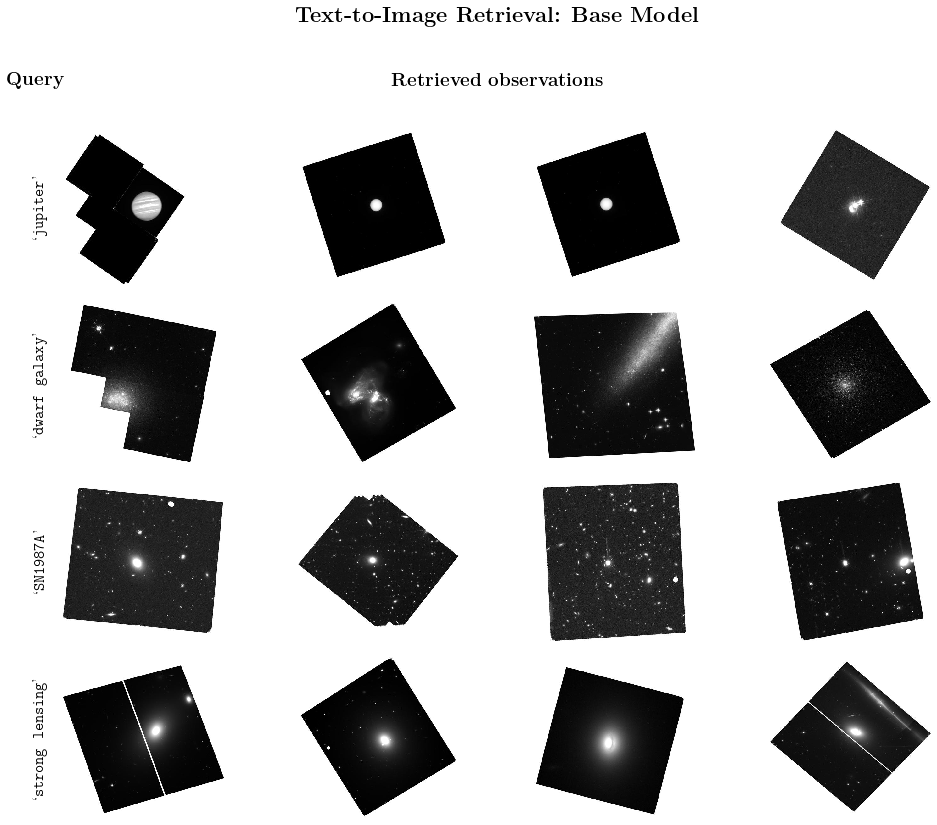

In [41]:
# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
queries = ["jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 16 * len(queries) / 5.))

# Add a main title
plt.suptitle(r"\textbf{Text-to-Image Retrieval: Base Model}", fontsize=22, fontweight='bold')

axes_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_base_feat_stack), text_feat[0]))[::-1]

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_base_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add the query name to the left of the first column
        if col == 0:
            plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')

# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.1, 0.9, r"\textbf{Query}", fontsize=19, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Retrieved observations}", fontsize=19, ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.1, hspace=0.1)
# plt.savefig("../paper/plots/tti_base.pdf", dpi=500)

In [43]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc
import matplotlib

rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{color}")
rc("text.latex", preamble=r"\usepackage{xcolor}")

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
# queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 
queries = ["Jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

sorted_idxs_list = []

save_dir = "../paper/plots/data/"

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_base_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    with open(save_dir + f"/query_tti_base_{row}.txt", 'w') as file:
        file.write(query)

    # Loop through the images for this query and plot them
    for col in range(m_cols):

        idx = sorted_idxs[col]

        plt.figure(figsize=(8,8))
        plt.imshow(get_image_from_stack(images_base_stack, idx))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_dir + f"/img_tti_base_{row}_{col}.pdf")
        plt.close()

        with open(save_dir + f"/propid_tti_base_{row}_{col}.txt", 'w') as file:
            idy = str(get_propid_phenomena(captions_base_stack[idx]))
            url = f"\\href{{https://archive.stsci.edu/proposal_search.php?id={idy}&mission=hst}}{{{idy}}}"
            file.write(url)

## Zero-shot classification

In [22]:
cleaned2_sum1 = []
with open("../data/sum1_gpt4.txt", "r") as file:
    for line in file:
        cleaned2_sum1.append(line.strip())

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

hubble_observation_categories = ["star forming galaxies", "lyman alpha", "dust", "crowded stellar field", "core-collapse supernova", "cosmology", "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "LSBGs", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "planetary nebulae", "supernova remnants", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar abundances", "stellar dynamics", "compact stellar remnants", "Einstein rings", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]

hubble_observation_categories_inputs = tokenizer(hubble_observation_categories, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes by Cos. Sim.:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

Text(0.5, 1.02, '\\textbf{Image-to-Text Retrieval}')

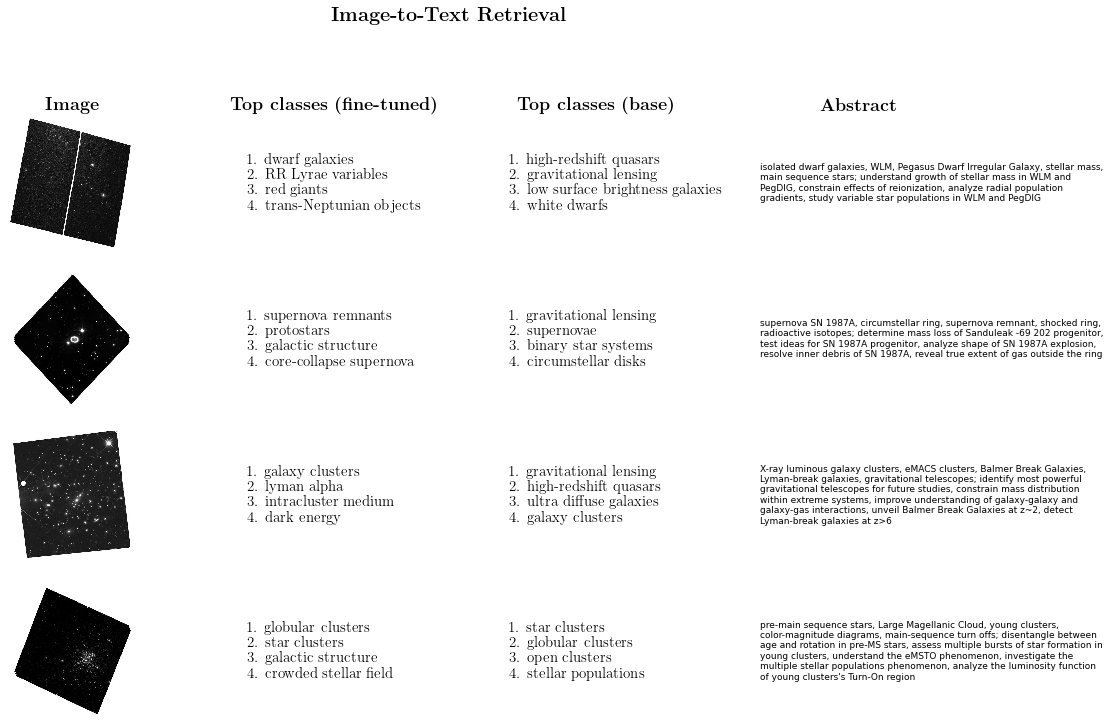

In [53]:
import matplotlib.pyplot as plt

# Assuming these functions and variables are already defined:
# model, inputs_images, claude_science_cat_inputs, restored_state, display_content, images, captions, claude_science_cat

indices = [2652, 230, 1744, 156]  # [sorted_idxs_list[i][0] for i in range(1, 4)] + [156]  # Replace with your list of indices
num_rows = len(indices)

# Adjust the figsize and width_ratios as needed
fig = plt.figure(figsize=(18, 11))  # Increased width for better layout
gs = gridspec.GridSpec(nrows=num_rows, ncols=4, width_ratios=[1, 1, 1, 1])


for row, idx in enumerate(indices):
    # Compute features, similarities, etc. as before

    image_feat = np.vstack(image_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=restored_state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Add image to the first column
    ax_img = fig.add_subplot(gs[row, 0])
    ax_img.imshow(get_image_from_stack(images_stack, idx))
    ax_img.axis('off')

    # Add science cases to the second column
    ax_science = fig.add_subplot(gs[row, 1])
    ax_science.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=15)
    ax_science.axis('off')

    image_feat = np.vstack(image_base_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Add science cases to the second column
    ax_science2 = fig.add_subplot(gs[row, 2])
    ax_science2.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=15)
    ax_science2.axis('off')

    # Add true abstract to the fourth column
    ax_abstract = fig.add_subplot(gs[row, 3])
    # Adjust the x-position and width of the text for better wrapping
    ax_abstract.text(0.05, 0.5, captions_stack[idx], va='center', ha='left',fontsize=9, wrap=True, usetex=False)
    ax_abstract.axis('off')

    if row == 0:
        ax_img.set_title(r"\textbf{Image}")
        ax_science.set_title(r"\textbf{Top classes (fine-tuned)}")
        ax_science2.set_title(r"\textbf{Top classes (base)}")
        ax_abstract.set_title(r"\textbf{Abstract}")

# Add a general title for the whole figure (optional)
fig.suptitle(r'\textbf{Image-to-Text Retrieval}', fontsize=20, y=1.02)

# Adjust layout and display the plot
# plt.tight_layout()
# plt.savefig("../paper/plots/itt_abs.pdf", bbox_inches='tight', dpi=500)

In [25]:
import matplotlib.pyplot as plt

# Assuming these functions and variables are already defined:
# model, inputs_images, claude_science_cat_inputs, restored_state, display_content, images, captions, claude_science_cat

indices = [2652, 230, 1744, 156]  # [sorted_idxs_list[i][0] for i in range(1, 4)] + [156]  # Replace with your list of indices
num_rows = len(indices)

for row, idx in enumerate(indices):
    # Compute features, similarities, etc. as before
    
    plt.figure(figsize=(8,8))
    plt.imshow(get_image_from_stack(images_stack, idx))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_dir + f"/img_itt_abs_{row}.pdf")
    plt.close()

    # FT model

    image_feat = np.vstack(image_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=restored_state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Write to file
    with open(save_dir + f"/sci_itt_abs_{row}.txt", 'w') as file:
        file.write(cats_text)

    # # Base model

    # image_feat = np.vstack(image_base_feat_stack)[idx]
    # text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=state.params)
    
    # cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    # ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    # cats_text = "\n".join(ranked_cats)

    # # Write to file
    # with open(save_dir + f"/sci_itt_base_{row}.txt", 'w') as file:
    #     file.write(cats_text)
    
    # Write abstract to file
    with open(save_dir + f"/abs_itt_abs_{row}.txt", 'w') as file:
        file.write(captions_stack[idx])